## Data Augmentation

In order to get the best results, neural networks need a lot of training data. In the case where the training data we have just isn't enough, we can add to the data using a trick called Data Augmentation.

Data Augmentation tricks classifiers into thinking we have more data than we do. We do this by applying simple transformations to the existing images. These transformations can be mirroring, rotating, lightening, darkening, saturating, desaturating, and many more simple actions. These help rule out unimportant details such as whether the vehicle is facing left or right, what color it is, or other simple changes that don't impact whether or not it is a car or a truck.

Data Augmentation is typically done online, meaning as the images are being fed into the network. Instead of copying the images and applying the transformations, and as a result bloating the space the images take up in memory, we apply the transformations during runtime and thus can have many more example images without having to take up more space or find more images.

Each time an image is used in training, a new random transformation is used to give a wide variety of data to work with.

It is important to note that the types of transformations will impact the results, so deciding what to use is critical. For example, mirroring an image will not change whether it is easily recognizable as a car or a truck, but in the case of recognizing handwriting, mirroring the image will have a significant impact on the result and potentially cause misclassifications

Keras has two methods of data augmentation: Including it in the data pipeline with ImageDataGenerator, and including it in the model definition using preprocessing layers.

In [6]:
# importing and setting up formatting
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec
import os, warnings
warnings.filterwarnings = True

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold',titlesize=18,titlepad=10)
plt.rc('image',cmap='magma')

ds_train_ = image_dataset_from_directory('train/',
                                         labels='inferred',
                                         label_mode='binary',
                                         image_size=[128, 128],
                                         interpolation='nearest',
                                         batch_size=64,
                                         shuffle=True)

ds_valid_ = image_dataset_from_directory('valid/',
                                         labels='inferred',
                                         label_mode='binary',
                                         image_size=[128, 128],
                                         interpolation='nearest',
                                         batch_size=64,
                                         shuffle=False)
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (ds_train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
ds_valid = (ds_valid_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


This section is for visualizing what each of the different transformations do

Any number of the preprocessing layers in "augment" can be commented or un-commented to show different transformations. The transformations with "factor" as a parameter can be adjusted between 0 and 1 to change the amount the image is transformed by. 

Re-running the cell will re-apply the transformations on a new image

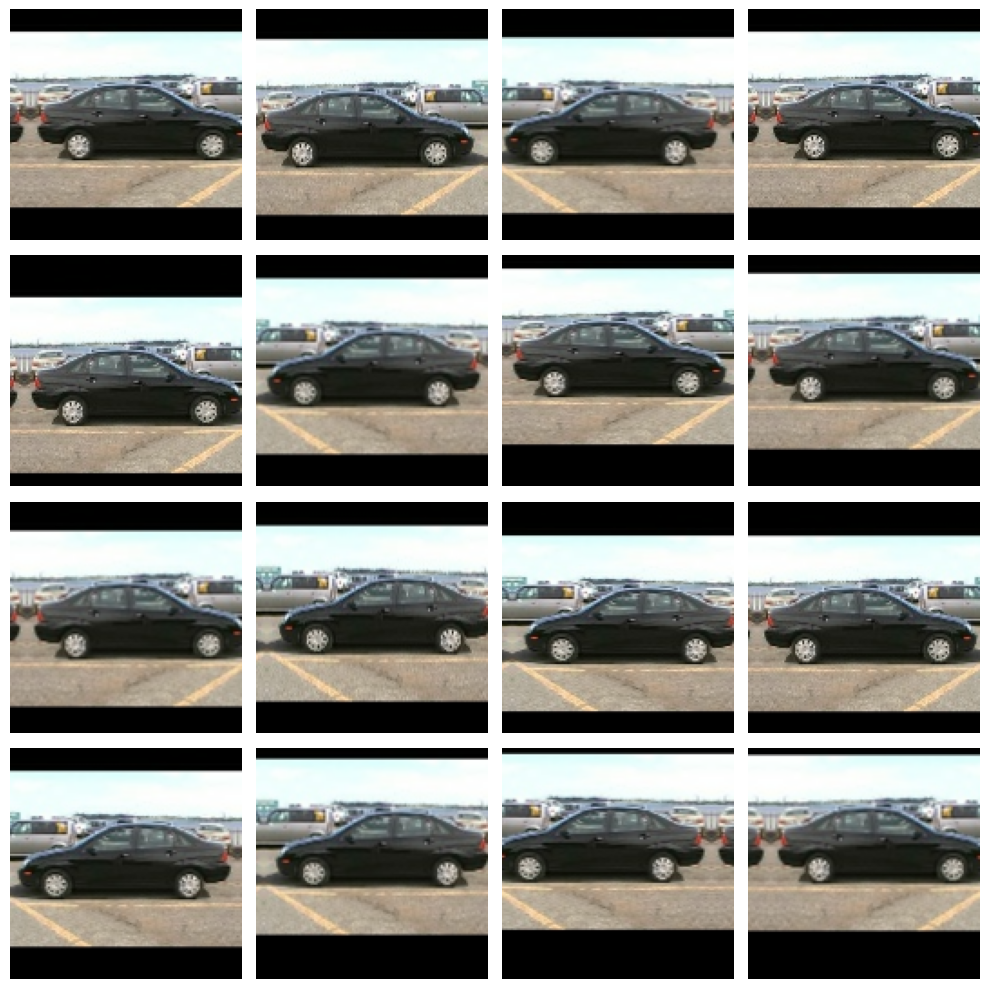

In [9]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

Now we build the model, this time using data augmentation layers to enhance the learning process

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [16]:
# Compile the model
optimizer= tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics=['binary_accuracy'])

## I recommend running this overnight

In [17]:
# Train
history = model.fit(ds_train, validation_data = ds_valid, epochs=50)

Epoch 1/50


80/80 [==============================] - 625s 8s/step - loss: 0.6688 - binary_accuracy: 0.5908 - val_loss: 0.6484 - val_binary_accuracy: 0.6139
Epoch 2/50
80/80 [==============================] - 593s 7s/step - loss: 0.6651 - binary_accuracy: 0.5880 - val_loss: 0.6906 - val_binary_accuracy: 0.5785
Epoch 3/50
80/80 [==============================] - 599s 8s/step - loss: 0.6880 - binary_accuracy: 0.5787 - val_loss: 0.6767 - val_binary_accuracy: 0.5773
Epoch 4/50
80/80 [==============================] - 525s 7s/step - loss: 0.6895 - binary_accuracy: 0.5869 - val_loss: 0.6784 - val_binary_accuracy: 0.6116
Epoch 5/50
80/80 [==============================] - 529s 7s/step - loss: 0.6759 - binary_accuracy: 0.6310 - val_loss: 0.6672 - val_binary_accuracy: 0.6228
Epoch 6/50
80/80 [==============================] - 509s 6s/step - loss: 0.6552 - binary_accuracy: 0.6602 - val_loss: 0.6228 - val_binary_accuracy: 0.6486
Epoch 7/50
80/80 [==============================] - 516s 6s/step - l

<Axes: >

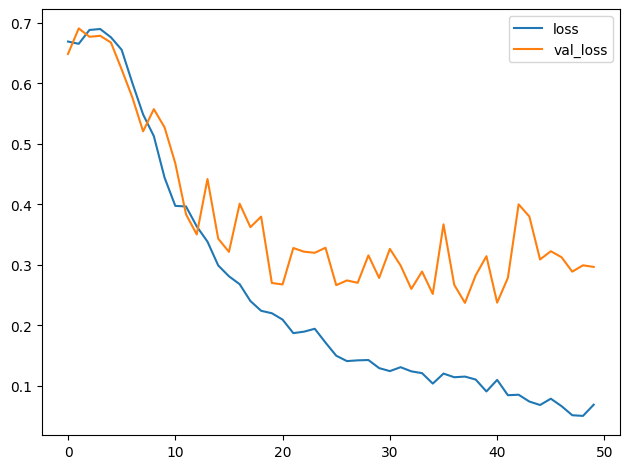

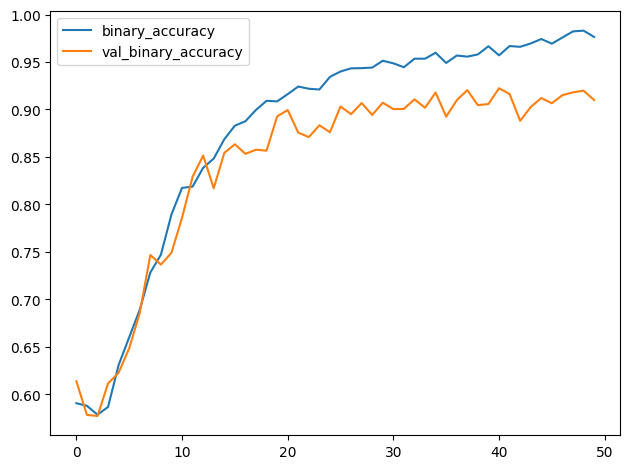

In [18]:
# Plot the learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

While this can lead to much better results, which transformations are performed is very important on the end result. This model seems to be overfitting possibly due to a lack of proper data. While we have supplemented the dataset with plenty of transformations, it may still need a more varied dataset or additional transformations applied. It would be interesting to train on a larger dataset or run different transformations.